# Merge news and stock prices

## Ordinary imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

In [2]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

## Import custom function to collect news and prices, work with file system and modelling

In [3]:
import trade_news_predict_prices

# Some constants (path, random seeed, api key)

In [4]:
general_constants = pd.read_csv('general_constants.txt', sep=',', delimiter = ",", header='infer', index_col='variable_name')
general_constants

,value
variable_name,
random_seed,420
directory_path,C:/DAN/t_systems/trade_news
folder_name_headlines,data/backup_headlines/
folder_name_logger,data/logger/
folder_name_merged_news_and_prices,data/merged_news_and_prices/
folder_name_for_labelling,data/for_labelling/
folder_name_for_labeled_news_iter1,data/labeled_news_iter1/
set_app_key1,ccebd1ff788d4574818be93e35c4741925ac214e
set_app_key2,a8be043d709946238759b0c5cb34c8f90d4e6f2c


In [5]:
# Path to folder with directory is a constant value that stores in .txt
# You can change them in some_constants.txt file or define them on your own.
directory_path = str(general_constants.loc['directory_path'][0])
random_seed = int(general_constants.loc['random_seed'][0])
print(random_seed)
print(directory_path)

420
C:/DAN/t_systems/trade_news


## Read files with labelling and with other info about news

In [6]:
labbeled_news_by_bert = pd.read_csv('data/' + 'labbeled_news_by_bert.csv')
print(labbeled_news_by_bert.shape)
labbeled_news_by_bert.head(2)

(368988, 2)


,storyId,labels_from_bert
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,"[0.011442418210208416, 0.9739800691604614, 0.0..."
1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,"[0.005342280492186546, 0.21854154765605927, 0...."


In [7]:
key_words_detection_df = pd.read_csv('data/' + "key_words_detection_df.csv")
print(key_words_detection_df.shape)
key_words_detection_df.head(1)

(399141, 109)


,ric,versionCreated,headline,storyId,sourceCode,story_wo_html,story_lang,Financial_Results_announces__s___Q1_Q2_Q3_Q4___result,Financial_Results__Q1_Q2_Q3_Q4___s__operating_profit,Financial_Results__Q1_Q2_Q3_Q4___s__sales,...,Eco_Issues_energy_management,Eco_Issues_sustainable,Eco_Issues_energy_efficient,Security_Protection_security_architecture,Security_Protection_security_requirement,Security_Protection_smartphone_security,Security_Protection_authentication,Security_Protection_hardware_attack,Security_Protection_verify_their_identity,Security_Protection_seamless_security
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,Igen Networks Corp. has joined the T-Mobile pa...,en,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
labbeled_news_by_bert_with_cols = key_words_detection_df[['storyId', 'ric', 'versionCreated', 'story_lang']].merge(
    labbeled_news_by_bert,
    on="storyId"
).drop_duplicates(keep='first',inplace=False, ignore_index=True)
labbeled_news_by_bert_with_cols.head(1)

,storyId,ric,versionCreated,story_lang,labels_from_bert
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,en,"[0.011442418210208416, 0.9739800691604614, 0.0..."


## News to daily format

In [9]:
import ast
# Convert string column to list of probabilities.
labbeled_news_by_bert_with_cols['labels_from_bert'] = labbeled_news_by_bert_with_cols['labels_from_bert'].apply(
    lambda x: ast.literal_eval(x)
)

In [10]:
# Predict rounded value of probability.
labbeled_news_by_bert_with_cols['labels_from_bert'] = labbeled_news_by_bert_with_cols['labels_from_bert'].apply(
    lambda x: [int(round(i, 0)) for i in x]
)
labbeled_news_by_bert_with_cols.head(2)

,storyId,ric,versionCreated,story_lang,labels_from_bert
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,urn:newsml:reuters.com:20201223:nNRAdspppv:1,TMUS.OQ,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
# Get columns names for splitted labels columns.
labelling_all_df = pd.read_csv('data/' + 'labelling_all_df.csv', sep=',')
order_of_col_labels = [k for k in list(labelling_all_df.columns) if 'my_label_' in k]
print(len(order_of_col_labels))

# Split columns with lists to several columns and define column names
labels_df_slice = pd.DataFrame(index=range(0, len(labbeled_news_by_bert_with_cols)), columns=[]).join(
    pd.DataFrame(labbeled_news_by_bert_with_cols['labels_from_bert'].to_list())
)
labels_df_slice.columns = order_of_col_labels

# Join these columns with labels to df
labbeled_news_by_bert_with_cols = labbeled_news_by_bert_with_cols.join(labels_df_slice)
labbeled_news_by_bert_with_cols.head(2)

18


,storyId,ric,versionCreated,story_lang,labels_from_bert,my_label_Analyst_Rating,my_label_Collaboration,my_label_Contract_-_Agreement_-_Deal,my_label_Credit_Debt_Rating,my_label_Dividend,...,my_label_Investigation,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,urn:newsml:reuters.com:20201223:nNRAdspppv:1,TMUS.OQ,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Create column with only date.
labbeled_news_by_bert_with_cols['date_only'] = labbeled_news_by_bert_with_cols['versionCreated'].apply(
    lambda x: x.split(" ")[0]
)

print(labbeled_news_by_bert_with_cols.shape)
labbeled_news_by_bert_with_cols.head(2)

(369553, 24)


,storyId,ric,versionCreated,story_lang,labels_from_bert,my_label_Analyst_Rating,my_label_Collaboration,my_label_Contract_-_Agreement_-_Deal,my_label_Credit_Debt_Rating,my_label_Dividend,...,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest,date_only
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-12-23
1,urn:newsml:reuters.com:20201223:nNRAdspppv:1,TMUS.OQ,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-12-23


In [14]:
# Try to convert dataframe with news to daily format for selected ric.
labbeled_news_by_bert_with_cols[
    labbeled_news_by_bert_with_cols['ric'] == 'USM.N'
].groupby(
    [labbeled_news_by_bert_with_cols['date_only']]
).sum() # .plot(kind='bar', stacked=True, width=0.95, figsize=(16,8))

,my_label_Analyst_Rating,my_label_Collaboration,my_label_Contract_-_Agreement_-_Deal,my_label_Credit_Debt_Rating,my_label_Dividend,my_label_Eco_Issues,my_label_Executive_Change,my_label_Financial_Results,my_label_Investigation,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest
date_only,,,,,,,,,,,,,,,,,,
2020-03-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-30,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [15]:
# And save the file with news
labbeled_news_by_bert_with_cols.to_csv('data/' + 'labbeled_news_by_bert_with_cols.csv', index=False, sep=';')

## For selected ric merge the price and news datasets to daily format

In [16]:
# Read the csv file with news
labbeled_news_by_bert_with_cols = pd.read_csv('data/' + 'labbeled_news_by_bert_with_cols.csv', sep=';')
labbeled_news_by_bert_with_cols.head(2)

,storyId,ric,versionCreated,story_lang,labels_from_bert,my_label_Analyst_Rating,my_label_Collaboration,my_label_Contract_-_Agreement_-_Deal,my_label_Credit_Debt_Rating,my_label_Dividend,...,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest,date_only
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-12-23
1,urn:newsml:reuters.com:20201223:nNRAdspppv:1,TMUS.OQ,2020-12-23 18:25:27.865000+00:00,en,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-12-23


In [18]:
# Read the file with all news texts to create a list with rics in it
# latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_headlines)
# all_headlines_df = pd.read_csv(latest_file, sep=';')
# all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
# print(all_headlines_df.shape, latest_file)

# Create the file with rics from all news texts dataset
# rics_list = list(all_headlines_df['ric'].value_counts().index)

# Or define this list faster with this constant list
rics_list = ['JPM.N', 'AMZN.OQ', 'FB.OQ', 'AAPL.OQ', 'MSFT.OQ', 'GOOGL.OQ', 'TSLA.OQ', 'BABA.N', 'PFE.N', 'RWEG.DE', 'VOWG_p.DE', 'BAC.N', 'NFLX.OQ', 'WMT.N', 'SIEGn.DE', 'LHAG.DE', 'DBKGn.DE', 'DIS.N', 'JNJ.N', 'XOM.N', 'INTC.OQ', 'DAIGn.DE', 'T.N', 'BMWG.DE', 'MRK.N', 'BAYGn.DE', 'CSCO.OQ', 'VZ.N', 'SAPG.DE', 'EONGn.DE', 'CRM.N', 'KO.N', 'CBKG.DE', 'MA.N', 'ALVG.DE', 'NKE.N', 'TKAG.DE', 'DTEGn.DE', 'NVDA.OQ', 'V.N', 'CMCSA.OQ', 'BRKa.N', 'UNH.N', 'BASFn.DE', 'PG.N', 'HD.N', 'TMUS.OQ', 'ABT.N', 'ABBV.N', 'PYPL.OQ', 'PEP.OQ', 'TMO.N', 'ADSGn.DE', 'DPWGn.DE', 'CONG.DE', 'LUMN.N', 'PSMGn.DE', 'MRCG.DE', 'IFXGn.DE', 'FREG.DE', 'HNKG_p.DE', 'FMEG.DE', 'ATUS.N', 'ADBE.OQ', 'CHTR.OQ', 'VNAn.DE', 'JCOM.OQ', 'HEIG.DE', 'O2Dn.DE', 'PDD.OQ', 'UTDI.DE', 'VG.OQ', 'FNTGn.DE', 'BEIG.DE', 'DRIG.DE', 'TIGO.OQ', 'BAND.OQ', 'TC1n.DE', 'IRDM.OQ', 'CABO.N', 'CCOI.OQ', 'USM.N', 'NFN.DE', 'E4CG.DE', 'PH6.F', 'IVV.P', 'VTI.P']

print(len(rics_list))

87


In [21]:
from datetime import timedelta 

prices_timeseries_folder = 'data/price_timeseries/'
merged_news_and_prices_folder = general_constants.loc['folder_name_merged_news_and_prices'][0]
interval = 'daily'
is_adjusted = 'adjusted'
# True - next trade day, False - previous trade day
to_allocate_holiday_news_to_next_trade_day = True
# +- dates to min max dates with news
timedelta_before_after_df = 30

for ric_now in rics_list:
    # Read the file with prices for that ric
    print(ric_now)
    try:
        file_name = 'price_timeseries_' + interval + '_' + is_adjusted + '_' + ric_now
        ric_prices = pd.read_csv(
            prices_timeseries_folder + file_name + '.csv', sep=';')
        print('Price file exists', end='. ')
    except Exception as e:
        print()
        print(' !! ERROR when trying to read file with prices.', ric_now, e)
        continue
    
    # Calculate lengths of prices and news dataframes
    len_prices_this_ric = len(ric_prices)
    len_news_this_ric = len(labbeled_news_by_bert_with_cols[
        labbeled_news_by_bert_with_cols['ric'] == ric_now
    ])
    
    print('Lengths of prices and news:', len_prices_this_ric, len_news_this_ric, end=', ')
    
    # If files are empty then start next ric iteration
    if len_prices_this_ric == 0 or len_news_this_ric == 0:
        print()
        print(' !! NO DATA')
        continue
    print('OK', end=', ')
    
    # News to daily format
    news_daily_for_one_ric = labbeled_news_by_bert_with_cols[
        labbeled_news_by_bert_with_cols['ric'] == ric_now
    ].groupby(
        [labbeled_news_by_bert_with_cols['date_only']]
    ).sum()
    news_daily_for_one_ric['Date'] = news_daily_for_one_ric.index

    # Create list of news types columns
    news_cols_list = list(news_daily_for_one_ric.columns)
    news_cols_list.remove('Date')

    one_of_the_column_of_news_daily = news_cols_list[0]
    one_of_the_column_of_prices = 'CLOSE'

    # print('Cols to check nan:', one_of_the_column_of_prices, ',', one_of_the_column_of_news_daily, end=', ')

    # Merge price and news
    merged_news_and_prices = ric_prices.merge(
        news_daily_for_one_ric,
        how='outer',
        on='Date'
    )

    # Change index to the dates
    merged_news_and_prices.index = merged_news_and_prices['Date']
    merged_news_and_prices['date_time'] =  pd.to_datetime(merged_news_and_prices['Date'], format='%Y-%m-%d')

    # Create list with dates which contains only news without prices.
    list_dates_with_news_but_without_prices = list(merged_news_and_prices[
        (np.isnan(merged_news_and_prices[one_of_the_column_of_prices])) &
        (np.isnan(merged_news_and_prices[one_of_the_column_of_news_daily]) == False)
    ].index)
    
    # If there are some dates of this kind then allocate them 
    if len(list_dates_with_news_but_without_prices) > 0:
        # Allocate news of dates without prices to dates with prices.
        # True - next trade day, False - previous trade day.
        # print('News replace to other date:   ', end='')
        for date_now in list_dates_with_news_but_without_prices:
            # Choose the date, which will absorb these news to itself
            if to_allocate_holiday_news_to_next_trade_day:
                allocate_to_this_date = merged_news_and_prices[
                    (merged_news_and_prices['date_time'] >= merged_news_and_prices.loc[date_now, 'date_time']) &
                    (np.isnan(merged_news_and_prices[one_of_the_column_of_prices]) == False)
                ]['date_time'].idxmin()
            else:
                allocate_to_this_date = merged_news_and_prices[
                    (merged_news_and_prices['date_time'] <= merged_news_and_prices.loc[date_now, 'date_time']) &
                    (np.isnan(merged_news_and_prices[one_of_the_column_of_prices]) == False)
                ]['date_time'].idxmax()
            # print(date_now[-2:], allocate_to_this_date[-2:], sep='--', end=';  ')
            # Allocate news from date_now to date with prices
            merged_news_and_prices.loc[allocate_to_this_date, news_cols_list] += merged_news_and_prices.loc[date_now, news_cols_list]
    
        # News of these dates are allocated, so let's drop these observations.
        merged_news_and_prices = merged_news_and_prices.drop(list_dates_with_news_but_without_prices)
    
    # Print dates allocation results
    print('Dates_to_allocate:', len(list_dates_with_news_but_without_prices),
         ', to next trade date:', to_allocate_holiday_news_to_next_trade_day)
    
    # Calculate min and max dates with news
    min_date_with_news = merged_news_and_prices[merged_news_and_prices[news_cols_list].sum(axis=1) > 0]['date_time'].idxmin()
    max_date_with_news = merged_news_and_prices[merged_news_and_prices[news_cols_list].sum(axis=1) > 0]['date_time'].idxmax()
    print(min_date_with_news, '<-->', max_date_with_news, end=', ')

    # Add columns with next days' close prices as labels for prediction model.
    # for i in range (-30, 0):
    #     new_col_name = 'y_' + str(-i)
    #     merged_news_and_prices[new_col_name] = merged_news_and_prices['CLOSE'].shift(periods=i)

    # Change nan to zeros in news cols before last available date with news.
    merged_news_and_prices[
        (merged_news_and_prices['date_time'] >= min_date_with_news) & # after min
        (merged_news_and_prices['date_time'] <= max_date_with_news) # before max
    ] = merged_news_and_prices[
        (merged_news_and_prices['date_time'] >= min_date_with_news) &
        (merged_news_and_prices['date_time'] <= max_date_with_news)
    ].fillna(0)

    # Cut df by newest/latest available dates with news +- several days.
    merged_news_and_prices = merged_news_and_prices[
        (merged_news_and_prices['date_time'] >= merged_news_and_prices.loc[min_date_with_news, 'date_time'] - timedelta(
            days=timedelta_before_after_df) ) & # several days before min
        (merged_news_and_prices['date_time'] <= merged_news_and_prices.loc[max_date_with_news, 'date_time'] + timedelta(
            days=timedelta_before_after_df) ) # several days after max
    ]

    # Save the df
    file_name = 'merged_news_and_prices_' + interval + '_' + is_adjusted + '_' + ric_now
    merged_news_and_prices.to_csv(merged_news_and_prices_folder + file_name + '.csv')
    print(file_name)

JPM.N
Price file exists. Lengths of prices and news: 2872 28183, OK, Dates_to_allocate: 130 , to next trade date: True
2019-11-04 <--> 2021-01-29, merged_news_and_prices_daily_adjusted_JPM.N
AMZN.OQ
Price file exists. Lengths of prices and news: 2872 23746, OK, Dates_to_allocate: 142 , to next trade date: True
2019-10-22 <--> 2021-01-15, merged_news_and_prices_daily_adjusted_AMZN.OQ
FB.OQ
Price file exists. Lengths of prices and news: 2273 22629, OK, Dates_to_allocate: 143 , to next trade date: True
2019-10-28 <--> 2021-01-22, merged_news_and_prices_daily_adjusted_FB.OQ
AAPL.OQ
Price file exists. Lengths of prices and news: 2872 20005, OK, Dates_to_allocate: 142 , to next trade date: True
2019-10-16 <--> 2021-01-08, merged_news_and_prices_daily_adjusted_AAPL.OQ
MSFT.OQ
Price file exists. Lengths of prices and news: 2872 17221, OK, Dates_to_allocate: 143 , to next trade date: True
2019-10-18 <--> 2021-01-15, merged_news_and_prices_daily_adjusted_MSFT.OQ
GOOGL.OQ
Price file exists. Lengt

In [22]:
merged_news_and_prices['date_time'].min()

Timestamp('2021-01-06 00:00:00')

In [23]:
np.isnan(merged_news_and_prices[one_of_the_column_of_news_daily][0])

True

In [24]:
merged_news_and_prices[
    (merged_news_and_prices['date_time'] >= min_date_with_news) &
    (merged_news_and_prices['date_time'] <= max_date_with_news)
] = merged_news_and_prices[
    (merged_news_and_prices['date_time'] >= min_date_with_news) &
    (merged_news_and_prices['date_time'] <= max_date_with_news)
].fillna(0)

In [25]:
merged_news_and_prices

,VALUE,VOLUME,HIGH,LOW,OPEN,CLOSE,COUNT,ric,Date,my_label_Analyst_Rating,...,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest,date_time
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-06,NaN,1208289,196.890,192.50,192.50,195.16,11990.0,VTI.P,2021-01-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-06
2021-01-07,NaN,919201,198.620,196.42,196.42,198.29,6917.0,VTI.P,2021-01-07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-07
2021-01-08,NaN,867568,199.460,197.00,199.14,199.25,8420.0,VTI.P,2021-01-08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-08
2021-01-11,NaN,667449,199.050,197.23,197.42,198.06,5317.0,VTI.P,2021-01-11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-11
2021-01-12,NaN,540469,198.990,197.35,198.37,198.76,5748.0,VTI.P,2021-01-12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-12
2021-01-13,NaN,495589,199.560,198.09,198.73,198.98,4645.0,VTI.P,2021-01-13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-13
2021-01-14,NaN,906012,200.030,198.52,199.55,198.79,10943.0,VTI.P,2021-01-14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-14
2021-01-15,NaN,555151,198.210,196.00,197.96,197.06,5990.0,VTI.P,2021-01-15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-15
2021-01-19,NaN,723828,199.030,197.83,198.66,198.86,4917.0,VTI.P,2021-01-19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-19


# Generate random news types and price to merge

In [51]:
from random import randrange
from datetime import datetime
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

## Generate random news types

In [52]:
# Create empty df
news_df_one_text = pd.DataFrame(index=range(0,10000), columns=[])
news_df_one_text['id'] = news_df_one_text.index
news_df_one_text['id'] = news_df_one_text['id'].apply(str)
news_df_one_text['id'] = news_df_one_text['id'] + '_id'

# Generate list with random date
d1 = datetime.strptime('1/11/2019 4:50 AM', '%m/%d/%Y %I:%M %p')
d2 = datetime.strptime('1/2/2021 1:30 PM', '%m/%d/%Y %I:%M %p')
random_date_list = []
for i in range(0, len(news_df_one_text)):
    random_date_list.append(str(random_date(d1, d2)))

# Add random date column
news_df_one_text['date'] = random_date_list

# Generate probabilities for labels.
news_df_one_text['labels'] = list((np.random.randint(0, 100 + 1, size=(len(news_df_one_text), 18)) / 100))

In [53]:
news_df_one_text

,id,date,labels
0,0_id,2019-01-17 03:39:23,"[0.14, 0.59, 0.42, 0.54, 0.84, 0.37, 0.6, 0.36..."
1,1_id,2020-07-22 03:59:52,"[0.54, 0.38, 0.77, 0.02, 0.98, 0.23, 0.82, 0.4..."
2,2_id,2019-07-25 16:51:14,"[0.29, 0.39, 0.33, 0.59, 0.01, 0.49, 0.31, 0.5..."
3,3_id,2019-08-05 02:28:06,"[0.72, 0.87, 1.0, 0.57, 0.07, 0.6, 0.15, 0.79,..."
4,4_id,2020-05-12 22:44:31,"[0.76, 0.85, 0.48, 0.83, 0.05, 0.18, 0.3, 0.53..."
...,...,...,...
9995,9995_id,2020-05-01 17:12:48,"[0.32, 0.68, 0.73, 0.52, 0.97, 0.06, 0.56, 0.8..."
9996,9996_id,2020-02-05 17:08:13,"[0.29, 0.75, 0.71, 0.93, 0.72, 0.49, 0.64, 0.8..."
9997,9997_id,2020-12-26 08:04:57,"[0.01, 0.18, 0.36, 0.82, 0.97, 0.2, 0.2, 0.66,..."
9998,9998_id,2020-06-02 03:00:19,"[0.11, 0.75, 0.6, 0.31, 0.11, 0.93, 0.58, 0.0,..."


In [54]:
# Predict rounded value of probability.
news_df_one_text['labels_int'] = news_df_one_text['labels'].apply(
    lambda x: [int(round(i, 0)) for i in x]
)
news_df_one_text.head(2)

,id,date,labels,labels_int
0,0_id,2019-01-17 03:39:23,"[0.14, 0.59, 0.42, 0.54, 0.84, 0.37, 0.6, 0.36...","[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
1,1_id,2020-07-22 03:59:52,"[0.54, 0.38, 0.77, 0.02, 0.98, 0.23, 0.82, 0.4...","[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, ..."


In [55]:
# Split columns with lists to several columns
news_df_one_text = news_df_one_text.join(
    pd.DataFrame(news_df_one_text['labels_int'].to_list())
)
news_df_one_text.head(2)

,id,date,labels,labels_int,0,1,2,3,4,5,...,8,9,10,11,12,13,14,15,16,17
0,0_id,2019-01-17 03:39:23,"[0.14, 0.59, 0.42, 0.54, 0.84, 0.37, 0.6, 0.36...","[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...",0,1,0,1,1,0,...,1,1,1,0,0,0,0,1,1,1
1,1_id,2020-07-22 03:59:52,"[0.54, 0.38, 0.77, 0.02, 0.98, 0.23, 0.82, 0.4...","[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, ...",1,0,1,0,1,0,...,1,1,1,0,0,1,1,1,0,0


In [56]:
# Convert date to datetime format
news_df_one_text['datetime_format'] = news_df_one_text['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
)
news_df_one_text['datetime_format'][0]

Timestamp('2019-01-17 03:39:23')

<AxesSubplot:xlabel='datetime_format'>

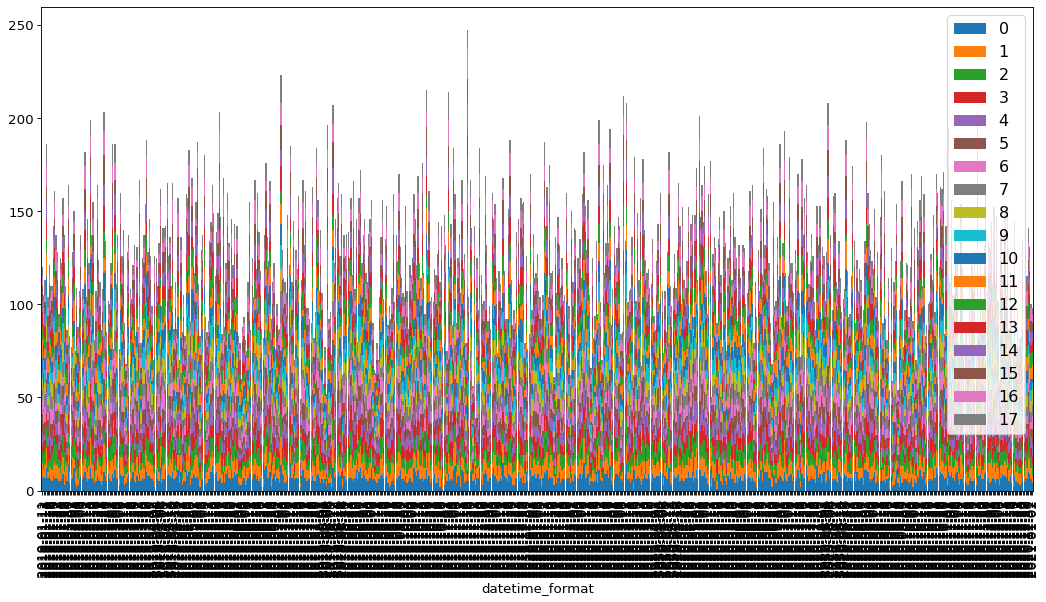

In [57]:
news_df_one_day = news_df_one_text.groupby(
    [news_df_one_text['datetime_format'].dt.date]
).sum()
news_df_one_day.plot(kind='bar', stacked=True, width=0.95, figsize=(16,8))

In [58]:
news_df_one_day['date'] = news_df_one_day.index
news_df_one_day['date'] = news_df_one_day['date'].apply(str)
news_df_one_day

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,date
datetime_format,,,,,,,,,,,,,,,,,,,
2019-01-11,7,8,6,3,7,10,8,5,6,3,8,10,7,8,6,8,5,5,2019-01-11
2019-01-12,8,3,8,7,3,7,6,2,8,3,8,7,4,4,5,6,9,7,2019-01-12
2019-01-13,7,7,8,5,3,7,8,7,6,7,6,5,6,6,7,6,4,8,2019-01-13
2019-01-14,12,11,11,7,12,7,10,10,11,13,11,12,8,10,10,8,12,11,2019-01-14
2019-01-15,7,3,6,8,5,9,4,4,4,7,6,8,4,5,8,6,4,6,2019-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29,6,6,8,8,5,3,4,5,6,7,6,8,5,9,6,7,8,8,2020-12-29
2020-12-30,10,8,10,8,7,10,7,8,5,5,8,6,9,10,8,5,9,8,2020-12-30
2020-12-31,9,8,6,6,8,6,8,7,8,8,6,6,8,11,9,4,7,6,2020-12-31


## Generate random prices

In [59]:
prices_daily = pd.DataFrame(index=[], columns=['Date', 'OPEN', 'CLOSE', 'MIN', 'MAX'])

# prices_daily['date'] = list(pd.date_range(start=d1.date(), end=d2.date()))
# prices_daily['date'] = prices_daily['date'].apply(str)

In [60]:
np.random.randint(-250, 350) / 10000

0.0151

<AxesSubplot:>

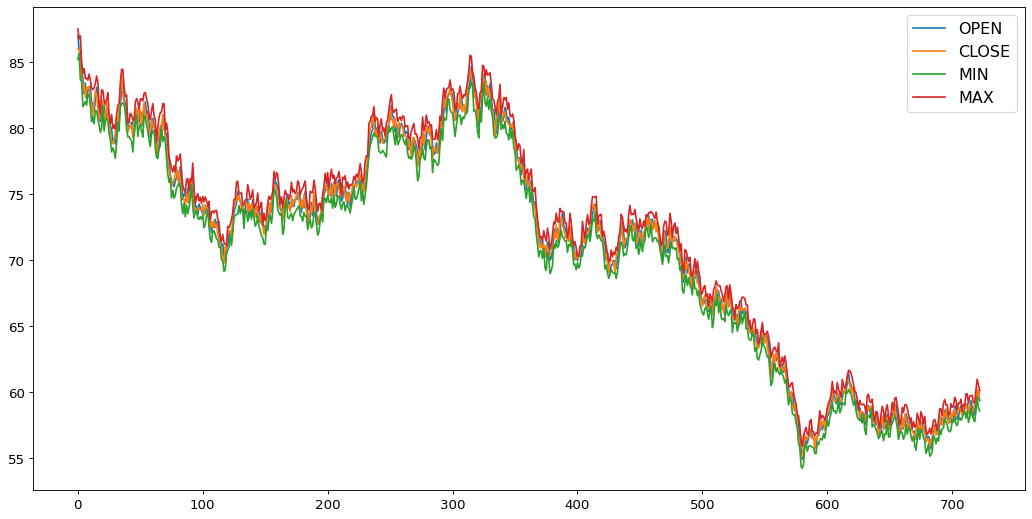

In [61]:
prices_daily = pd.DataFrame(index=[], columns=['Date', 'OPEN', 'CLOSE', 'MIN', 'MAX'])

close_price = 87.5

for i in pd.date_range(start=d1.date(), end=d2.date()):
    
    open_price = close_price * (1 + np.random.randint(-50, 50) / 10000)
        
    close_price = open_price * (1 + np.random.randint(-150, 155) / 10000)
    max_price = max(open_price, close_price) * (1 + np.random.randint(0, 150) / 10000)
    min_price = min(open_price, close_price) * (1 - np.random.randint(0, 150) / 10000)
    
    prices_daily = prices_daily.append(
        {'Date': str(i),
         'OPEN': open_price,
         'CLOSE': close_price,
         'MIN': min_price,
         'MAX': max_price,
        }, 
        ignore_index=True
    )

prices_daily.plot(figsize=(16,8))

In [62]:
prices_daily['Date'] = prices_daily['Date'].apply(
    lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
)

## Merge random data

In [63]:
prices_daily.index = prices_daily['Date']
prices_daily.head(2)

,Date,OPEN,CLOSE,MIN,MAX
Date,,,,,
2019-01-11,2019-01-11,87.062500,86.061281,85.226487,87.532638
2019-01-12,2019-01-12,85.949402,85.983781,85.657174,86.792029


In [64]:
news_df_one_day.index = news_df_one_day['date']
news_df_one_day.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,date
date,,,,,,,,,,,,,,,,,,,
2019-01-11,7,8,6,3,7,10,8,5,6,3,8,10,7,8,6,8,5,5,2019-01-11
2019-01-12,8,3,8,7,3,7,6,2,8,3,8,7,4,4,5,6,9,7,2019-01-12


In [65]:
prices_news_merged_df = pd.concat([prices_daily, news_df_one_day], axis=1)
prices_news_merged_df.head(2)

,Date,OPEN,CLOSE,MIN,MAX,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,date
2019-01-11,2019-01-11,87.062500,86.061281,85.226487,87.532638,7,8,6,3,7,...,3,8,10,7,8,6,8,5,5,2019-01-11
2019-01-12,2019-01-12,85.949402,85.983781,85.657174,86.792029,8,3,8,7,3,...,3,8,7,4,4,5,6,9,7,2019-01-12


In [66]:
# for period_now in range (1, 6):
#     new_loc_name = 'y_' + str(period_now)
#     prices_news_merged_df[new_loc_name] = prices_news_merged_df['CLOSE'].shift(periods=period_now, fill_value=None)

# prices_news_merged_df.head(6)

In [67]:
prices_news_merged_df.to_csv(path_project_folder + 'random_prices_news_merged_df.csv', index=False, sep=';')